In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
import matplotlib.pylab as plt
import healpy as hp
import time
import  lsst.sims.featureScheduler.basis_functions as bf 
import lsst.sims.featureScheduler.surveys as surveys


In [2]:
survey_length = 365.25*10  # days
nside = 32
years = np.round(survey_length/365.25)
t0 = time.time()

sun_ra_0 = 3.277 # radians
offset = fs.utils.create_season_offset(nside, sun_ra_0)

even_year_target = fs.utils.standard_goals(nside=nside)
odd_year_target = fs.utils.standard_goals(nside=nside)
zero_year_target = fs.utils.standard_goals(nside=nside)

up = 1.75
down = 0.25


# Let's find the healpix that divides the WFD area in half
wfd = even_year_target['r'] * 0
wfd[np.where(even_year_target['r'] == 1)] = 1
wfd_accum = np.cumsum(wfd)
split_indx = np.max(np.where(wfd_accum < wfd_accum.max()/2.))

indx = np.arange(even_year_target['r'].size)
top_half_wfd = np.where((even_year_target['r'] == 1) & (indx <= split_indx))
bottom_half_wfd = np.where((even_year_target['r'] == 1) & (indx > split_indx))
top_half_wfd[0].size, bottom_half_wfd[0].size

pair_time = 22.
times_needed = [pair_time, pair_time*2]


for filtername in even_year_target:
    even_year_target[filtername][top_half_wfd] *= up
    even_year_target[filtername][bottom_half_wfd] *= down

    odd_year_target[filtername][top_half_wfd] *= down
    odd_year_target[filtername][bottom_half_wfd] *= up

# These should be the same. Slight differences from distrete pixel number roundoff I think
even_norm = fs.utils.calc_norm_factor(even_year_target)
odd_norm = fs.utils.calc_norm_factor(odd_year_target)
z_norm = fs.utils.calc_norm_factor(zero_year_target)

survey_list = []

mod_year = 2

# Set up observations to be taken in blocks
filter1s = ['u', 'g', 'r', 'i', 'z', 'y']
filter2s = [None, 'g', 'r', 'i', None, None]
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(bf.M5_diff_basis_function(filtername=filtername2, nside=nside))
    target_list = [even_year_target[filtername], odd_year_target[filtername],
                   zero_year_target[filtername]]
    bfs.append(bf.Target_map_modulo_basis_function(filtername=filtername,
                                                target_maps=target_list,
                                                season_modulo=mod_year, day_offset=offset,
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=even_norm))
    if filtername2 is not None:
        bfs.append(bf.Target_map_modulo_basis_function(filtername=filtername2,
                                                    target_maps=target_list,
                                                    season_modulo=mod_year, day_offset=offset,
                                                    out_of_bounds_val=np.nan, nside=nside,
                                                    norm_factor=even_norm))
    bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
    bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
    
    bfs.append(bf.Clouded_out_basis_function())
    filternames = [fn for fn in [filtername, filtername2] if fn is not None]
    bfs.append(bf.Filter_loaded_basis_function(filternames=filternames))
    if filtername2 is None:
        time_needed = times_needed[0]
    else:
        time_needed = times_needed[1]

    
    
    
    bfs.append(bf.Time_to_twilight_basis_function(time_needed=time_needed))
    bfs.append(bf.Not_twilight_basis_function())
    
    weights = np.array([3.0, 3.0, 0.3, 0.3, 3., 3., 0., 0, 0, 0, 0])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works properly.
        weights = np.array([6.0, 0.6, 3., 3., 0., 0, 0, 0, 0])
    # XXX-
    # This is where we could add a look-ahead basis function to include m5_diff in the future.
    # Actually, having a near-future m5 would also help prevent switching to u or g right at twilight?
    # Maybe just need a "filter future" basis function?
    if filtername2 is None:
        survey_name = 'blob, %s' % filtername
    else:
        survey_name = 'blob, %s%s' % (filtername, filtername2)
    survey_list.append(surveys.Blob_survey(bfs, weights, filtername1=filtername, filtername2=filtername2,
                                   ideal_pair_time=pair_time, nside=nside,
                                    survey_note=survey_name, ignore_obs='DD', dither=True))

# Set up the greedy surveys for filling time when can't take pairs.
filters = ['u', 'g', 'r', 'i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(bf.M5_diff_basis_function(filtername=filtername, nside=nside))
    target_list = [even_year_target[filtername], odd_year_target[filtername],
                   zero_year_target[filtername]]
    bfs.append(bf.Target_map_modulo_basis_function(filtername=filtername,
                                                target_maps=target_list,
                                                season_modulo=mod_year, day_offset=offset,
                                                out_of_bounds_val=np.nan, nside=nside,
                                                norm_factor=even_norm))

    bfs.append(bf.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(bf.Strict_filter_basis_function(filtername=filtername))
    bfs.append(bf.Zenith_shadow_mask_basis_function(nside=nside, shadow_minutes=60., max_alt=76.))
    weights = np.array([3.0, 0.3, 3., 3., 0.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    sv = surveys.Greedy_survey(bfs, weights, block_size=1, filtername=filtername,
                                 dither=True, nside=nside, ignore_obs='DD')
    greedy_surveys.append(sv)

# Set up the DD surveys
dd_surveys = fs.surveys.generate_dd_surveys()

survey_list_o_lists = [dd_surveys, survey_list, greedy_surveys]


In [3]:

scheduler = fs.schedulers.Core_scheduler(survey_list_o_lists, nside=nside)
n_visit_limit = None
observatory =  Model_observatory(nside=nside)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='rolling_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:279: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:441: UserWarning: overriding requested rotSkyPos value
  warnings.warn('overriding requested rotSkyPos value')


progress = 100.0%Skipped 0 observations
Flushed 21 observations from queue for being stale
Completed 2468088 observations
ran in 417 min = 7.0 hours


/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/sim_runner.py:98: UserWarning: Failed to get info about run, may need to run scons in some pacakges.
  warnings.warn('Failed to get info about run, may need to run scons in some pacakges.')


In [4]:
conditions = observatory.return_conditions()
reward = scheduler.survey_lists[1][2].calc_reward_function(conditions)

/Users/yoachim/gitRepos/sims_skybrightness_pre/python/lsst/sims/skybrightness_pre/SkyModelPre.py:377: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')
/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/modelObservatory/model_observatory.py:279: RuntimeWarning: invalid value encountered in less
  slewtimes[np.where(slewtimes < 0)] = np.nan


In [5]:
np.degrees(conditions.sunAlt)

-12.016966072291982

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


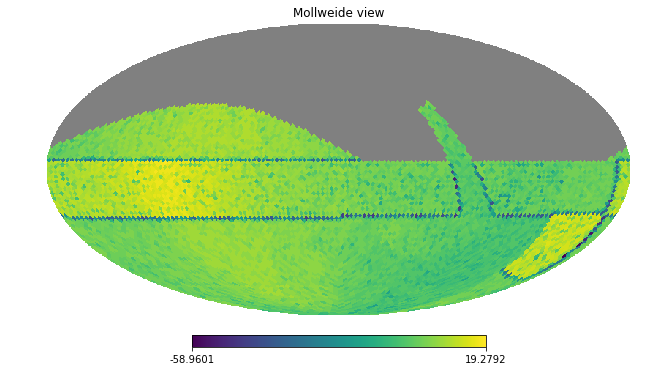

In [6]:
hp.mollview(scheduler.survey_lists[1][1].basis_functions[3](conditions))

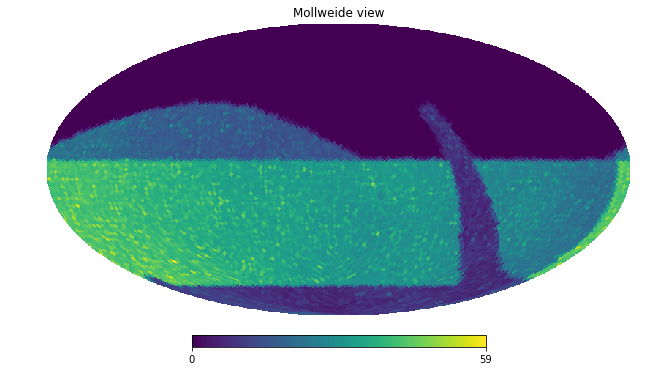

In [7]:
hp.mollview(scheduler.survey_lists[1][2].basis_functions[3].survey_features['N_obs_-1'].feature)

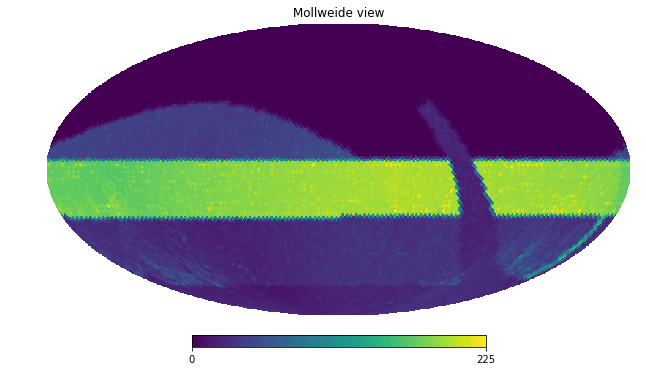

In [8]:
hp.mollview(scheduler.survey_lists[1][2].basis_functions[3].survey_features['N_obs_0'].feature)

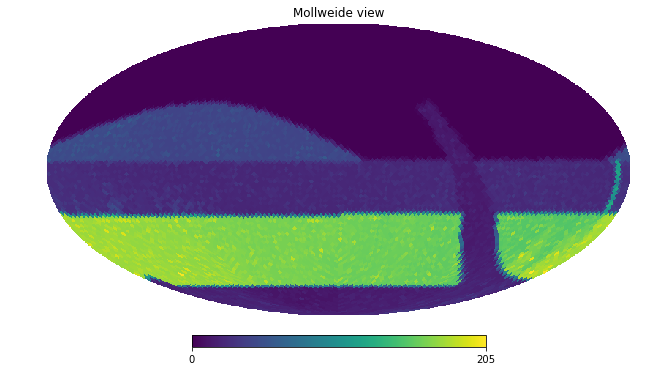

In [13]:
hp.mollview(scheduler.survey_lists[1][2].basis_functions[3].survey_features['N_obs_1'].feature)

In [9]:
scheduler.survey_lists[1][2].basis_functions[3].survey_features['N_obs_count_all_0'].feature

1057292

In [10]:
observations[0]['sunRA']


3.2771850574162991

In [11]:
nside = 32
t0 = time.time()

sun_ra_0 = 3.277 # radians
offset = fs.utils.create_season_offset(nside, sun_ra_0)


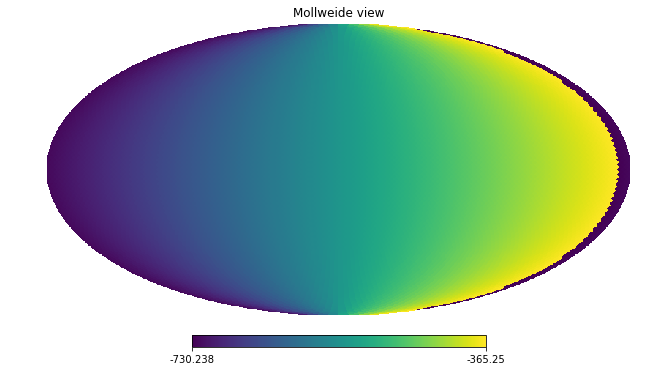

In [12]:
hp.mollview(offset)